In [31]:
!pip install matplotlib 

  Using cached matplotlib-3.7.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)


In [1]:
import os
import time
import librosa
# import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.callbacks import *

import warnings
warnings.filterwarnings('ignore')

In [44]:
path = os.getcwd() + "/npy_dataset/"
path

'/root/npy_dataset/'

In [3]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

/root/npy_dataset//train
/root/npy_dataset//val
/root/npy_dataset//test


In [4]:
def data_loader(path):
    X = []
    Y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X.append(feature)
            Y.append(label)
    return X, Y

In [5]:
X_train, Y_train = data_loader(TRAINING_DIR)
X_val, Y_val = data_loader(VALIDATION_DIR)
X_test, Y_test = data_loader(TEST_DIR)

In [6]:
print("There are {} training samples and {} training labels".format(len(X_train), len(Y_train)))
print("There are {} validation samples and {} validation labels".format(len(X_val), len(Y_val)))
print("There are {} testing samples and {} testing labels".format(len(X_test), len(Y_test)))

There are 14000 training samples and 14000 training labels
There are 2000 validation samples and 2000 validation labels
There are 4000 testing samples and 4000 testing labels


In [7]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))

Shape of X_train: (14000, 32319)
Shape of X_val: (2000, 32319)
Shape of X_test: (4000, 32319)


In [8]:
# Reshape the input data
X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], 1) )
X_val = X_val.reshape( (X_val.shape[0], X_val.shape[1], 1) )
X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], 1) )
Y_train = Y_train.reshape( (Y_train.shape[0], 1) )
Y_val = Y_val.reshape( (Y_val.shape[0], 1) )
Y_test = Y_test.reshape( (Y_test.shape[0], 1) )

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))

Shape of X_train: (14000, 32319, 1)
Shape of X_val: (2000, 32319, 1)
Shape of X_test: (4000, 32319, 1)


In [9]:
# shuffle the dataset
shuffle_index = np.random.permutation(len(X_train))
X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]
shuffle_index = np.random.permutation(len(X_val))
X_val, Y_val = X_val[shuffle_index], Y_val[shuffle_index]
shuffle_index = np.random.permutation(len(X_test))
X_test, Y_test = X_test[shuffle_index], Y_test[shuffle_index]

In [10]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.fit_transform(Y_val)
Y_test = label_encoder.fit_transform(Y_test)

In [11]:
model = Sequential([
    layers.Input(shape=(X_train.shape[1:])),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(512, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

2023-07-14 20:42:58.742850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32317, 16)         64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 16158, 16)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16156, 32)         1568      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8078, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8076, 64)          6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4038, 64)          0

In [13]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [14]:
epochs = 300
batch_size = 128
current_time = int(time.time())
stop_training_callback = earlystopper
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val), 
                    callbacks=[stop_training_callback])
print("Training completed in {} seconds.".format(int(time.time()-current_time)))

2023-07-14 20:44:00.324160: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1809864000 exceeds 10% of free system memory.
2023-07-14 20:44:02.093862: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1809864000 exceeds 10% of free system memory.


Epoch 1/300


2023-07-14 20:44:08.068990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-14 20:44:10.920710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-14 20:44:11.702827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f409fd996c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-14 20:44:11.702877: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-14 20:44:11.749846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-14 20:44:11.963178: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

110/110 [==============================] - 99s 779ms/step - loss: 0.6452 - accuracy: 0.5757 - val_loss: 0.6078 - val_accuracy: 0.6605
Epoch 2/300
110/110 [==============================] - 38s 350ms/step - loss: 0.5569 - accuracy: 0.7196 - val_loss: 0.5424 - val_accuracy: 0.7520
Epoch 3/300
110/110 [==============================] - 38s 346ms/step - loss: 0.5145 - accuracy: 0.7531 - val_loss: 0.5227 - val_accuracy: 0.7765
Epoch 4/300
110/110 [==============================] - 37s 341ms/step - loss: 0.4870 - accuracy: 0.7730 - val_loss: 0.5013 - val_accuracy: 0.7880
Epoch 5/300
110/110 [==============================] - 35s 317ms/step - loss: 0.4566 - accuracy: 0.7886 - val_loss: 0.4616 - val_accuracy: 0.7970
Epoch 6/300
110/110 [==============================] - 37s 334ms/step - loss: 0.4268 - accuracy: 0.8071 - val_loss: 0.4383 - val_accuracy: 0.8015
Epoch 7/300
110/110 [==============================] - 38s 344ms/step - loss: 0.4088 - accuracy: 0.8149 - val_loss: 0.4096 - val_accurac

Epoch 57/300
110/110 [==============================] - 15s 138ms/step - loss: 0.1528 - accuracy: 0.9373 - val_loss: 0.1385 - val_accuracy: 0.9430
Epoch 58/300
110/110 [==============================] - 16s 142ms/step - loss: 0.1482 - accuracy: 0.9421 - val_loss: 0.1350 - val_accuracy: 0.9450
Epoch 59/300
110/110 [==============================] - 12s 111ms/step - loss: 0.1495 - accuracy: 0.9394 - val_loss: 0.1352 - val_accuracy: 0.9460
Epoch 60/300
110/110 [==============================] - 14s 132ms/step - loss: 0.1490 - accuracy: 0.9381 - val_loss: 0.1319 - val_accuracy: 0.9485
Epoch 61/300
110/110 [==============================] - 12s 113ms/step - loss: 0.1442 - accuracy: 0.9442 - val_loss: 0.1400 - val_accuracy: 0.9420
Epoch 62/300
110/110 [==============================] - 15s 137ms/step - loss: 0.1444 - accuracy: 0.9411 - val_loss: 0.1274 - val_accuracy: 0.9500
Epoch 63/300
110/110 [==============================] - 15s 134ms/step - loss: 0.1334 - accuracy: 0.9470 - val_loss: 0

110/110 [==============================] - 12s 111ms/step - loss: 0.0815 - accuracy: 0.9688 - val_loss: 0.0778 - val_accuracy: 0.9670
Epoch 113/300
110/110 [==============================] - 12s 111ms/step - loss: 0.0779 - accuracy: 0.9704 - val_loss: 0.0884 - val_accuracy: 0.9640
Epoch 114/300
110/110 [==============================] - 12s 112ms/step - loss: 0.0798 - accuracy: 0.9692 - val_loss: 0.0830 - val_accuracy: 0.9680
Epoch 115/300
110/110 [==============================] - 12s 110ms/step - loss: 0.0827 - accuracy: 0.9687 - val_loss: 0.0781 - val_accuracy: 0.9665
Epoch 116/300
110/110 [==============================] - 12s 111ms/step - loss: 0.0768 - accuracy: 0.9714 - val_loss: 0.0808 - val_accuracy: 0.9650
Epoch 117/300
110/110 [==============================] - 12s 111ms/step - loss: 0.0839 - accuracy: 0.9704 - val_loss: 0.0792 - val_accuracy: 0.9685
Epoch 118/300
110/110 [==============================] - 12s 113ms/step - loss: 0.0801 - accuracy: 0.9695 - val_loss: 0.0826 -

110/110 [==============================] - 12s 111ms/step - loss: 0.0491 - accuracy: 0.9831 - val_loss: 0.0688 - val_accuracy: 0.9720
Epoch 168/300
110/110 [==============================] - 12s 111ms/step - loss: 0.0444 - accuracy: 0.9851 - val_loss: 0.0645 - val_accuracy: 0.9745
Epoch 169/300
110/110 [==============================] - 12s 114ms/step - loss: 0.0492 - accuracy: 0.9808 - val_loss: 0.0670 - val_accuracy: 0.9730
Epoch 170/300
110/110 [==============================] - 12s 111ms/step - loss: 0.0506 - accuracy: 0.9824 - val_loss: 0.0726 - val_accuracy: 0.9750
Epoch 171/300
110/110 [==============================] - 15s 137ms/step - loss: 0.0564 - accuracy: 0.9787 - val_loss: 0.0601 - val_accuracy: 0.9705
Epoch 172/300
110/110 [==============================] - 15s 141ms/step - loss: 0.0513 - accuracy: 0.9817 - val_loss: 0.0591 - val_accuracy: 0.9770
Epoch 173/300
110/110 [==============================] - 12s 110ms/step - loss: 0.0462 - accuracy: 0.9827 - val_loss: 0.0719 -

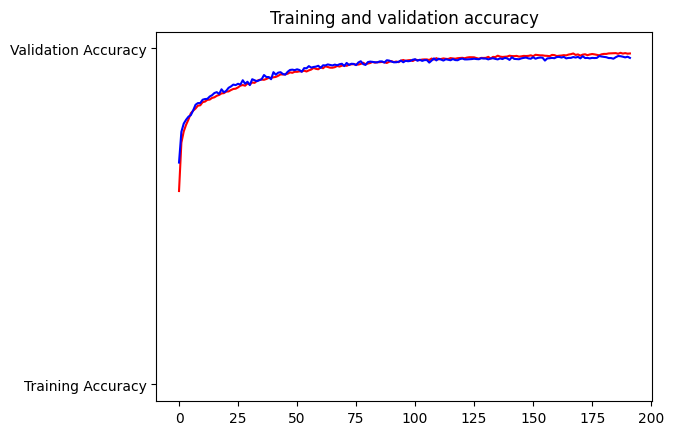

AttributeError: module 'matplotlib' has no attribute 'pyplot'

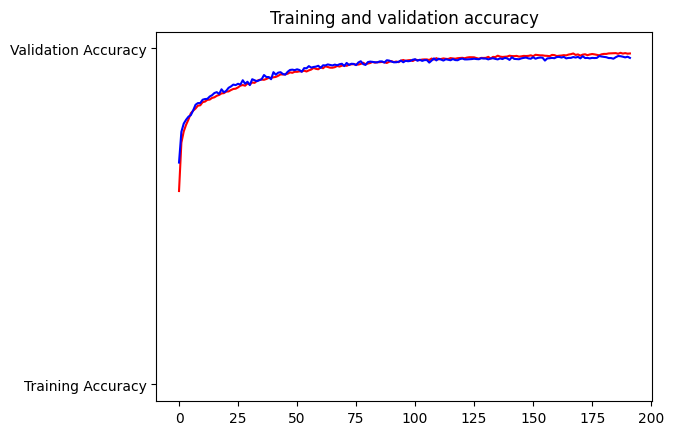

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [15]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [16]:
test_predict = model.predict(X_test)

125/125 [==============================] - 2s 9ms/step


In [17]:
test_score = roc_auc_score(Y_test, test_predict)
print(f"StackNet AUC on testing set: {round(test_score, 4)}")

StackNet AUC on testing set: 0.9959


In [18]:
show_test_predict = np.round(test_predict, 0)
show_test_predict = pd.DataFrame(show_test_predict)
print(show_test_predict)
print(len(show_test_predict))

        0
0     1.0
1     1.0
2     1.0
3     0.0
4     0.0
...   ...
3995  1.0
3996  1.0
3997  0.0
3998  0.0
3999  0.0

[4000 rows x 1 columns]
4000


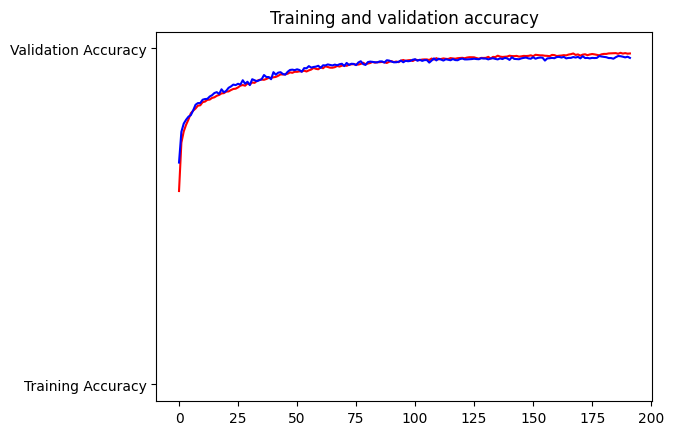

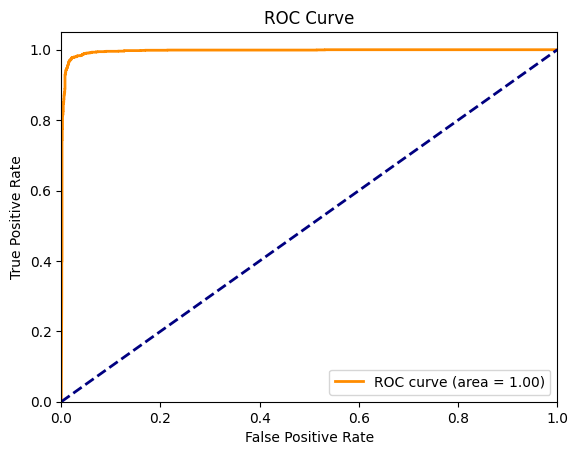

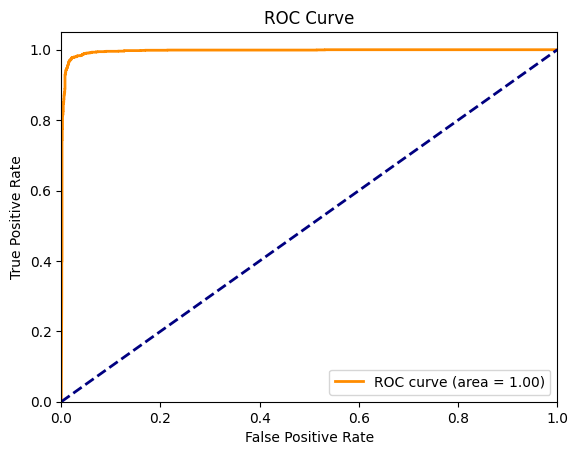

AttributeError: module 'matplotlib' has no attribute 'pyplot'

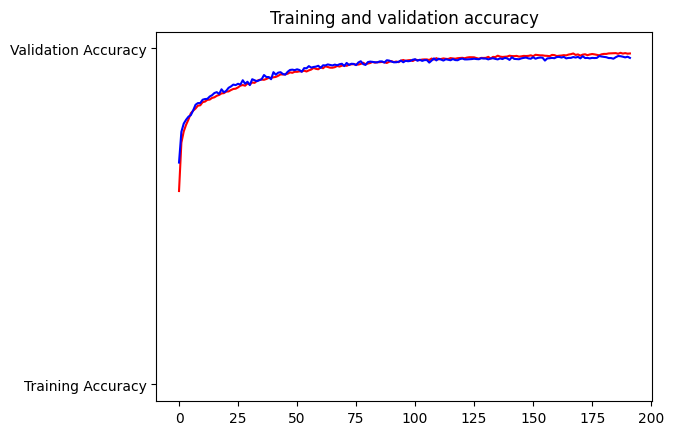

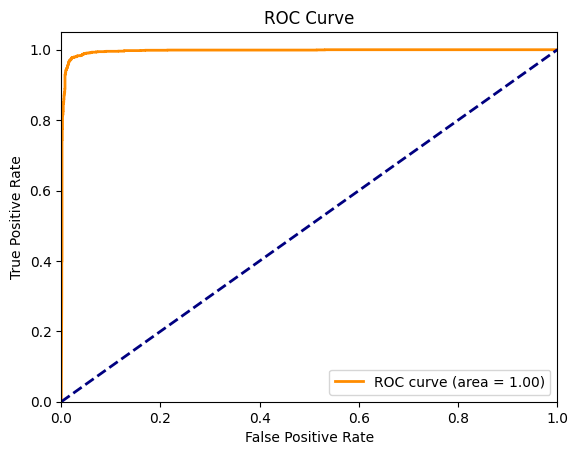

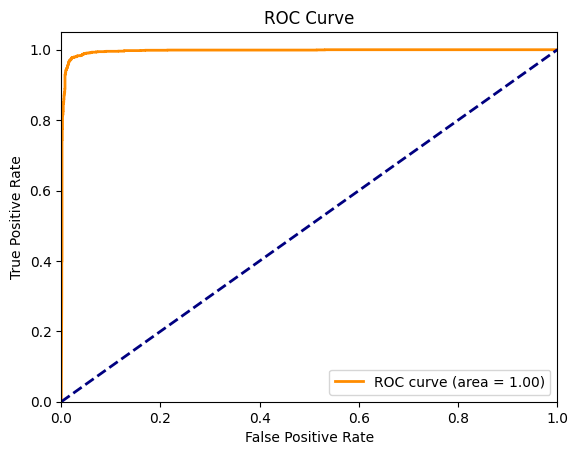

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [25]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, test_predict)
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [28]:
plt.plot([1,2,3,4,5])

In [20]:
from sklearn.metrics import f1_score
f1_score(Y_test, show_test_predict, average='macro')

0.9772499872031177

In [21]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(Y_test, show_test_predict)
display(cf)

array([[1953,   47],
       [  44, 1956]])

In [22]:
stt = model.evaluate(X_test, Y_test)
print(stt)

125/125 [==============================] - 1s 11ms/step - loss: 0.0879 - accuracy: 0.9772
[0.08789880573749542, 0.9772499799728394]


In [23]:
print(classification_report(Y_test, show_test_predict))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2000
           1       0.98      0.98      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [24]:
model.save("1D_CNN_Model_98acc.h5")

In [3]:
cf = np.array([[1953,   47],
       [  44, 1956]])

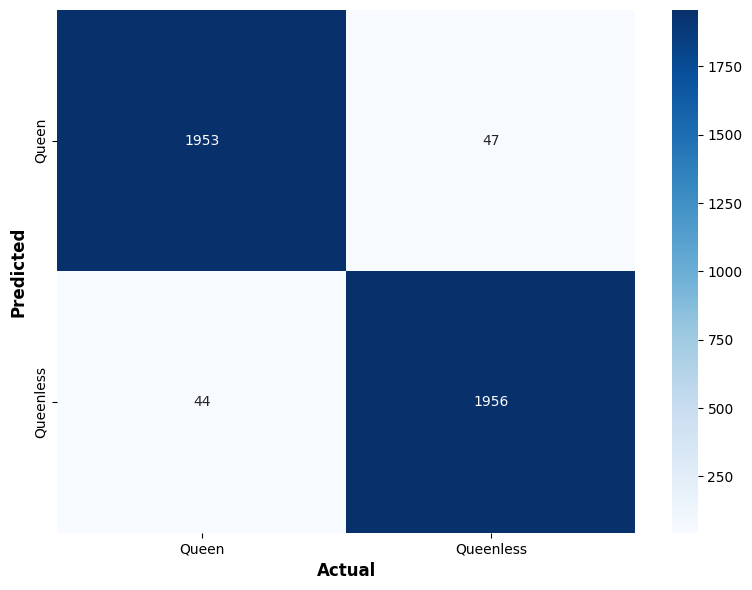

In [5]:
label = ["Queen", "Queenless"]
plt.figure(figsize=(8,6))
sns.heatmap(cf, annot=True, xticklabels=label, yticklabels=label, cmap= 'Blues', fmt='g')
plt.xlabel('Actual',fontsize=12, fontweight='bold')
plt.ylabel('Predicted', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()